# Dipolar Droplets: critical atom number study

<a href="https://colab.research.google.com/github/viktorcikojevic/dipolar-droplets/blob/main/critical_atom_number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:

import numpy as np
import random
from numpy import loadtxt
from scipy.optimize import curve_fit
import os
import matplotlib.pyplot as plt

import scipy.special
from scipy.optimize import fmin


In [64]:
# Get QMC data
import gdown

url = 'https://drive.google.com/uc?id=1RrM7HvxheAc7hO1sZUiJu0LdBrvr3u9L'
gdown.download(url, "energies-qmc.zip", quiet=False)

url = "https://drive.google.com/uc?id=1P_gBl2XgPKTweoVxLQcyi2brr9_H5gNB"
gdown.download(url, "experimental-data.zip", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1RrM7HvxheAc7hO1sZUiJu0LdBrvr3u9L
To: /Users/viktorcikojevic/Documents/dipolar-droplets/energies-qmc.zip
100%|██████████| 94.2k/94.2k [00:00<00:00, 1.01MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_gBl2XgPKTweoVxLQcyi2brr9_H5gNB
To: /Users/viktorcikojevic/Documents/dipolar-droplets/experimental-data.zip
100%|██████████| 2.36k/2.36k [00:00<00:00, 8.02MB/s]


'experimental-data.zip'

In [65]:
!unzip -n energies-qmc.zip
!unzip -n experimental-data.zip

Archive:  energies-qmc.zip
Archive:  experimental-data.zip


# Functions for $n_c$ estimation

In [66]:


def fdip(x):
    x  = x + 0.*1j
    EPS = 1.E-10
    res = np.piecewise(x, [np.abs(x-1) < EPS, np.abs(x-1) >= EPS], [0.+0.j, lambda x: (1 + 2.*x**2) / (1 - x**2) - 3*x**2*np.arctanh(np.sqrt(1-x**2)) / (1 - x**2)**1.5])
    return res.real 


def enFit(x, b, c):
    return b*x**c


def en_harmonic_oscillator(sr, sz):
     # calculate energy of the quantum harmonic oscillator with N particles and harmonic length harmonic_length
    return 0.5 * (sr**2 / 10000**2 + sz**2 / 100000**2)


def en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=True):
    kappa = sr / sz
    kin = 0.25 * (2./sr**2 + 1./sz**2) 
    N = nparticles
    en_mflhy = np.sqrt(2)*np.pi**(-1.5)*N*alpha/(4*sr**2*sz) + np.pi**(-1.5*gamma)*beta*np.exp(gamma*np.log(N) - 2*gamma*np.log(sr) - gamma*np.log(sz))/(gamma + 1)**(3/2)
    en_int  = en_mflhy +  N/(2*(2*np.pi)**1.5 * sr**2 * sz) * (- 4*np.pi/3 * fdip(kappa) ) 
    return kin   + en_int  + (en_harmonic_oscillator(sr, sz) if include_ho else 0)

def min_en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=True):
      return np.min(en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho))

def local_minima(array2d):
    # find local minima in 2d array.
    # Returns array of indices of local minima
    # True if the point is a local minimum
    return ((array2d <= np.roll(array2d,  1, 0)) &
            (array2d <= np.roll(array2d, -1, 0)) &
            (array2d <= np.roll(array2d,  1, 1)) &
            (array2d <= np.roll(array2d, -1, 1)))

def estimate_critical_atom_number(alpha, beta, gamma, include_ho=True, based_on='energy'):
    # Critical atom number is the number of atoms for which the energy of a system crosses zero.
    # The energy of a system is given by the second element of the tuple returned by en_particles.
    # The first element of the tuple is the optimal x_0.
    # Implement the root-finding algorithm to find the critical atom number
    # The function should return the critical atom number and the optimal x_0 for that atom number
    # The function should also return the energy of the system for the critical atom number.
    nparticles = 3*10**5

    

    

    iter_num = 0
    
    # Run the code below if the based_on is 'energy'
    if based_on == 'energy':
        ng = 500
        sr_range = np.linspace(4, 200, ng)
        sz_range = np.linspace(4, 2000, ng)
        # make meshgrid
        sr, sz = np.meshgrid(sr_range, sz_range)
        while True:
            nparticles_new = nparticles * 0.95
            en_0 = min_en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=False)
            en_1 = min_en_per_particle(sr, sz, nparticles_new, alpha, beta, gamma, include_ho=False)
            if en_0 * en_1 < 0 and en_0 < 0 and en_1 > 0:
                break
            nparticles = nparticles_new
            iter_num += 1
            if iter_num > 4000:
                # Raise value error
                raise ValueError("Too many iterations")
                # break the will loop
                break
        return nparticles, en_0
        
    if based_on == 'size':
        ng = 500
        sr_range = np.linspace(0.1, 200, ng)
        sz_range = np.linspace(0.1, 2000, ng)
        # make meshgrid
        sr, sz = np.meshgrid(sr_range, sz_range)
        
        # Calculate the critical atom number in the following way:
        # 1. Find if there is a local minima of the energy for a given number of atoms
        # 2. if there exists local minimum, decrease the number of atoms. If not, break the loop
        while True:
            en_0 = en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=False)
            local_min = local_minima(en_0)
            
            # if there exists local minimum, decrease the number of atoms. If not, break the loop
            if np.sum(local_min) > 0:
                nparticles_new = nparticles * 0.95
                nparticles = nparticles_new
                
                # print the sr and sz values for the local minima
                sr_local_min = sr.flatten()[local_min.flatten()]
                sz_local_min = sz.flatten()[local_min.flatten()]
                print(f"nparticles: {nparticles}, sr_local_min: {sr_local_min}, sz_local_min: {sz_local_min}")
                
                if np.min(en_0) > 0 and (np.min(sr_local_min) > sr_range[-2] or np.min(sz_local_min) > sz_range[-2]):
                    break
                
                iter_num += 1
                if iter_num > 4000 or nparticles < 10:
                    # Raise value error
                    raise ValueError("Too many iterations")
                    # break the will loop
                    break
            else:
                break

        nc = nparticles
        return nc, np.min(en_0)

## Physics parameters

In [67]:
a_s = 91.401702191
r_0 = 387.6   # https://www.wolframalpha.com/input?i=%28162Dy+mass%29+*+%28mu_0%29+*+%289.93+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# r_0 = 393.14   # https://www.wolframalpha.com/input?i=%28162+atomic+mass+unit%29+*+%28mu_0%29+*+%2810+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# r_0 = 398 # https://www.wolframalpha.com/input?i=%28164+atomic+mass+unit%29+*+%28mu_0%29+*+%2810+bohr+magneton%29%5E2+%2F+%284+pi+hbar%5E2%29+%2F+%28bohr+radius%29
# From Raul’s Thesis: m is the atomic mass, and Cdd = μ0 μ^2 sets the strength of the dipolar
# interaction, with μ = 9.93μB the magnetic dipole moment of 162Dy. We use dipolar units,
# obtained from the characteristic dipolar length r0 = m C_dd/ (4π \hbar^2) = 387.672168a0 and the
# dipolar scale of energy 0 = ~2
# 

## Test the $N_c$ function

In [68]:
# These are the MF+LHY estimations from IGOR. Let's try to reproduce some of these
!cat experimental-data/mean_field_IGOR.dat  

#a	N
60.5970075184  550.962558145
62.7356641274  630.484693517
64.8743207365  721.484505403
66.7271283591  798.254461363
68.8657849681  913.469004347
70.8615170839  1027.84403302
72.7158135034  1176.19595118
74.853725714  1323.46689853
76.9931267214  1540.22653908
78.9896032357  1762.532214
80.5587950671  1983.2180518
82.6974516761  2269.46206612
84.5532368924  2686.04636111
87.4057715689  3288.07864054
89.4044812784  3957.78164425
91.401702191  4605.99379639
93.9721098732  5930.74447925
96.3988486638  7383.40961091
98.2561226769  9038.277145
99.8275477035  10697.3506182



In [69]:

a_s = 91.401702191
a_s = a_s / r_0
alpha = 2*np.pi*a_s # * (1 - 1 / (3*(a_s / r_0)))
beta = 256*np.sqrt(np.pi)*a_s**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt(a_s)/45
gamma = 1.5

n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, include_ho=False, based_on='size')
n_c_best_possible_fit, min_energy

nparticles: 285000.0, sr_local_min: [38.15711423 37.75651303 37.35591182], sz_local_min: [1394.81983968 1414.85891784 1438.90581162]
nparticles: 270750.0, sr_local_min: [37.35591182 36.95531062], sz_local_min: [1378.78857715 1398.82765531]
nparticles: 257212.5, sr_local_min: [37.35591182 36.95531062 36.55470942], sz_local_min: [1322.67915832 1342.71823647 1362.75731463]
nparticles: 244351.875, sr_local_min: [36.55470942 36.15410822], sz_local_min: [1310.65571142 1330.69478958]
nparticles: 232134.28125, sr_local_min: [36.15410822 35.75350701], sz_local_min: [1274.58537074 1294.6244489 ]
nparticles: 220527.56718749998, sr_local_min: [35.75350701 35.35290581], sz_local_min: [1242.52284569 1262.56192385]
nparticles: 209501.18882812498, sr_local_min: [35.75350701 35.35290581 34.95230461], sz_local_min: [1194.42905812 1214.46813627 1234.50721443]
nparticles: 199026.12938671873, sr_local_min: [35.35290581 34.95230461 34.55170341], sz_local_min: [1166.3743487  1182.40561122 1202.44468938]
npar

(5778.815938771343, 9.96970220024108e-06)

In [70]:
ng = 400
sr_range = np.linspace(4, 100, ng)
sz_range = np.linspace(4, 1000, ng)
# make meshgrid
sr, sz = np.meshgrid(sr_range, sz_range)
nparticles = 100

np.min(en_per_particle(sr, sz, nparticles, alpha, beta, gamma, include_ho=False))

4.994387305328081e-05

In [71]:
# r_0 = 360.375
a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]

# Recipe 7: STEP 1: Fit the $E_{\rm kin}/N$ to a function of the form $\alpha \rho + \beta\rho^\gamma$. Step 2: Use $\beta\rho^\gamma$ instead of the LHY term



a_s = 110.0, popt[alpha,beta,gamma]=[0.11883385 3.28002703 1.52530295]


a_s = 101.572, popt[alpha,beta,gamma]=[0.22125297 3.19806879 1.59521286]


a_s = 90.0, popt[alpha,beta,gamma]=[-0.04210241  2.23638408  1.35239519]


a_s = 80.0, popt[alpha,beta,gamma]=[0.27080808 2.38773351 1.56886656]


a_s = 70.0, popt[alpha,beta,gamma]=[ 2.16761928e+03 -2.16630151e+03  9.99907699e-01]


a_s = 60.0, popt[alpha,beta,gamma]=[0.48306191 2.22129791 1.79371164]


(0.0, 0.21837499999999999)

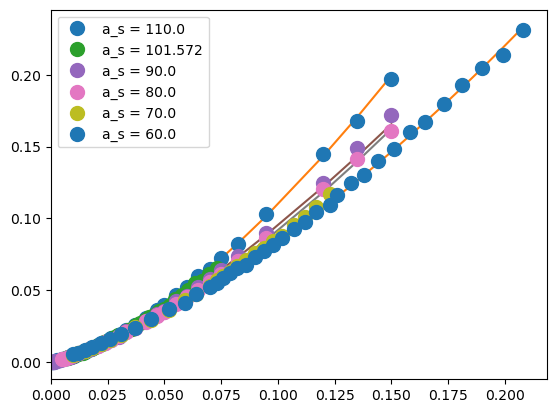

In [72]:
 
for i in range(len(a_s)):
    data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
    # print("Reading data", "energies-qmc/" + file[i])
    rho_all = data[:, 0]
    
    en_all = data[:, 1] #  -  data[:,7]
    sen_all = data[:, 2]  # - data[:,6]
    kin_en = data[:, 3]
    sen_kin = data[:, 4]
    
    alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
    
    
    plt.errorbar(rho_all, kin_en, sen_kin, label=f"a_s = {a_s[i]}", marker='o', markersize=10, linestyle='None')
    
    # STEP 1: Fit the energy to a function of the form a*x + b*x**c
    def enFit(x, a, b, c):
        return a*x + b*x**c
    popt, pcov = curve_fit(enFit, rho_all , kin_en,sigma=sen_kin, maxfev=10000)
    
    print(f"\n\na_s = {a_s[i]}, popt[alpha,beta,gamma]={popt}")
    # sort rho_all
    idx = np.argsort(rho_all)
    rho_all = rho_all[idx]
    plt.plot(rho_all, enFit(rho_all, *popt))
        

    
plt.legend()
# plt.ylim(0, 3)
plt.xlim(0)
# plt.xlim(0, 0.03), plt.ylim(-0.02, 0)

# Estimate $n_c$ with recipe 7

In [73]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/critical-atom-numbers/recipe-7-nc
fout = open(f"results/critical-atom-numbers/recipe-7-nc/functionals_E_N.dat", 'w', buffering=1)
# fout.write("# {rho_min_x} {a_s[i]} {popt[0]} {popt[1]} {popt[2]} {n_c}\n")
# Write the first line, which is the header: string_out = f"{a_s[i]:.2f}  {n_c_best_possible_fit:.5e}  {rho_min_x:.3e} {rho_max_x:.3e} {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}    \n"
string_out = f"# a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  \n"
fout.write(string_out)
for rho_min_x in np.arange(0.4, 0.81, 0.1):
  for rho_max_x in np.arange(1.5, 2.91, 0.2):
    for i in range(len(a_s)):
        rho_min = rho_min_x * rho_0_arr
        rho_max = rho_max_x * rho_0_arr


        print(f"analyzing a_s = {a_s[i]:.3f}")

        data = loadtxt("energies-qmc/data_clean/" + file[i],  float)
        print("Reading data", "energies-qmc/" + file[i])
        rho_all = data[:, 0]
        en_all = data[:, 1] #  -  data[:,7]
        sen_all = data[:, 2]  # - data[:,6]
        kin_en = data[:,3]
        sen_kin = data[:,4]        

        en_all = en_all

        w = np.logical_and(rho_all > rho_min[i], rho_all < rho_max[i])
        rho_all_w = rho_all[w]
        en_all_w = kin_en[w]
        sen_all_w = sen_kin[w]

        try:
            
            alpha_mf = 2*np.pi*(a_s[i] / r_0) # * (1 - 1 / (3*(a_s[i] / r_0)))
            alpha_cherny = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            
            def enFit(x, a, b, c):
              return a*x + b*x**c
            
            
            
            popt, pcov = curve_fit(enFit, rho_all_w, en_all_w,sigma=sen_all_w, maxfev=10000)
            alpha, beta, gamma = popt
            alpha = alpha_mf
            n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, based_on='size')
            
            
            
            alpha_opt = popt[0]
            # popt[0] = 2*np.pi*(a_s[i] / r_0)  * (1 - 1 / (3*(a_s[i] / r_0)))
            # n_c_alpha_cherny = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0)  
            # n_c_alpha_mf = estimate_critical_atom_number(popt)

            # popt[0] = 2*np.pi*(a_s[i] / r_0) / 10  
            # n_c_alpha_mf_over_10 = estimate_critical_atom_number(popt)

            # string_out = f"{rho_min_x} {a_s[i]} {alpha_opt} {popt[1]} {popt[2]} {n_c_best_possible_fit} {n_c_alpha_cherny} {n_c_alpha_mf} {n_c_alpha_mf_over_10} \n"
            string_out = f"{a_s[i]:.2f}  {n_c_best_possible_fit:.5e}  {rho_min_x:.3e} {rho_max_x:.3e} {alpha:.5e} {popt[0]:.5e} {popt[1]:.5e} {popt[2]:.5e}    \n"
            fout.write(string_out)
            print(string_out)
        except Exception as error:
            print('Caught this error: ' + repr(error))


mkdir: results/critical-atom-numbers/recipe-7-nc: File exists
analyzing a_s = 110.000
Reading data energies-qmc/as110.dat
nparticles: 285000.0, sr_local_min: [39.35891784 38.95831663 38.55771543], sz_local_min: [1438.90581162 1458.94488978 1482.99178357]
nparticles: 270750.0, sr_local_min: [38.95831663 38.55771543 38.15711423], sz_local_min: [1402.83547094 1422.8745491  1442.91362725]
nparticles: 257212.5, sr_local_min: [38.55771543 38.15711423 37.75651303], sz_local_min: [1362.75731463 1382.79639279 1406.84328657]
nparticles: 244351.875, sr_local_min: [38.15711423 37.75651303 37.35591182], sz_local_min: [1330.69478958 1346.7260521  1370.77294589]
nparticles: 232134.28125, sr_local_min: [37.75651303 37.35591182 36.95531062], sz_local_min: [1294.6244489  1314.66352705 1334.70260521]
nparticles: 220527.56718749998, sr_local_min: [37.35591182 36.95531062 36.55470942], sz_local_min: [1262.56192385 1278.59318637 1298.63226453]
nparticles: 209501.18882812498, sr_local_min: [36.95531062 36.55

# Estimate $n_c$ with recipe 42: MFLHY

In [74]:

a_s = np.array([110, 101.572,  90, 80, 70, 60])
file = ["as110.dat", "as100.dat", "as90.dat", "as80.dat", "as70.dat", "as60.dat"]
# extension = "_2" #is either "" or "_2"
enmax = np.array([0.015, 0.03, 0.05, 0.05])
# approximate estimate of equilibrium density
# rho_0_arr = np.array([0.018133025814418047, 0.022067711461453077,  0.03056689762975153,  0.03896986119629473]) 
rho_0_arr = np.array([0.02 , 0.025 ,  0.03 ,  0.04, 0.05, 0.069]) 
rho_max_arr = 2.0 * rho_0_arr

!mkdir results/critical-atom-numbers/recipe-42-nc
fout = open(f"results/critical-atom-numbers/recipe-42-nc/functionals_E_N.dat", 'w', buffering=1)
# write header string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {min_energy:.5e}   \n"
string_out = f"# a_s  n_c_best_possible_fit  rho_min_x  rho_max_x  alpha  alpha_opt  beta  gamma  min_energy  \n"
fout.write(string_out)
for i in range(len(a_s)):
    print(f"analyzing a_s = {a_s[i]:.5f}")
    try:        
        alpha = 2*np.pi*(a_s[i]/r_0) # * (1 - 1 / (3*(a_s / r_0)))
        beta = 256*np.sqrt(np.pi)*(a_s[i]/r_0)**(5/2)/15 + 128*np.sqrt(np.pi)*np.sqrt((a_s[i]/r_0))/45

        gamma = 1.5
        n_c_best_possible_fit, min_energy = estimate_critical_atom_number(alpha, beta, gamma, based_on="size")
        string_out = f"{a_s[i]:.2f} {n_c_best_possible_fit:.5e} {rho_min_x:.4e} {rho_max_x:.4e}  {min_energy:.5e}   \n"
        fout.write(string_out)
        print(string_out)
    except Exception as error:
        print('Caught this error: ' + repr(error))


mkdir: results/critical-atom-numbers/recipe-42-nc: File exists
analyzing a_s = 110.00000
nparticles: 285000.0, sr_local_min: [87.83166333], sz_local_min: [2000.]
nparticles: 270750.0, sr_local_min: [86.62985972], sz_local_min: [2000.]
nparticles: 257212.5, sr_local_min: [85.02745491], sz_local_min: [2000.]
nparticles: 244351.875, sr_local_min: [84.22625251], sz_local_min: [2000.]
nparticles: 232134.28125, sr_local_min: [83.0244489], sz_local_min: [2000.]
nparticles: 220527.56718749998, sr_local_min: [81.82264529], sz_local_min: [2000.]
nparticles: 209501.18882812498, sr_local_min: [81.02144289], sz_local_min: [2000.]
nparticles: 199026.12938671873, sr_local_min: [80.22024048], sz_local_min: [1987.97655311]
nparticles: 189074.8229173828, sr_local_min: [80.22024048], sz_local_min: [1939.88276553]
nparticles: 179621.08177151365, sr_local_min: [79.81963928], sz_local_min: [1899.80460922]
nparticles: 170640.02768293797, sr_local_min: [79.41903808], sz_local_min: [1859.72645291]
nparticles: 

# Plot critical atom number

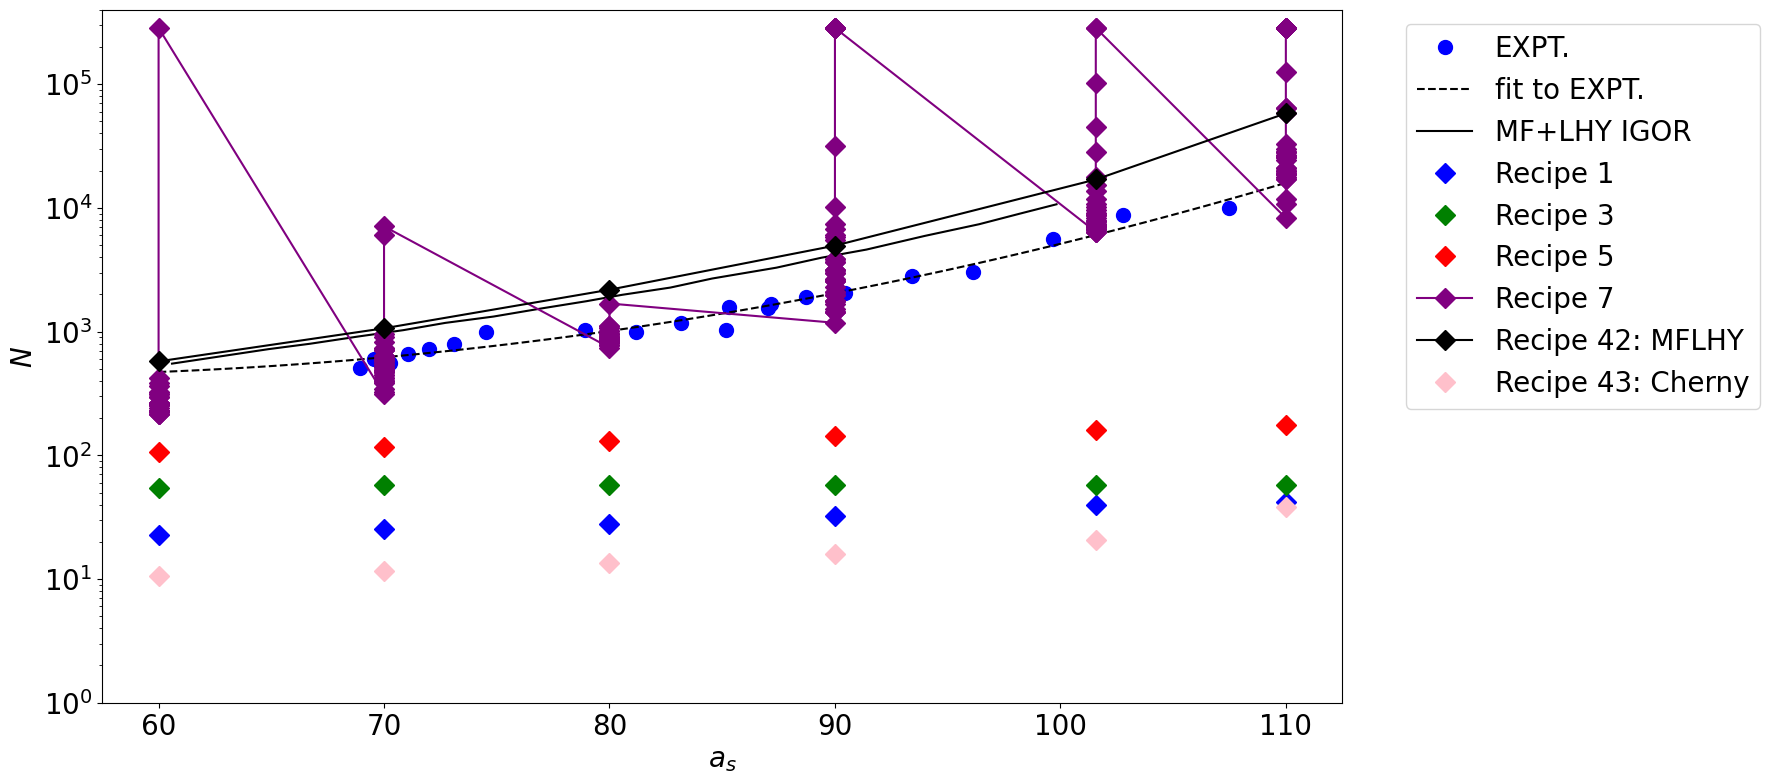

In [75]:

plt.figure(figsize=(16, 9))

def log_func_fit(x, a, b, c):
    return a*x**2 + b*x + c
def func_fit(x, a, b, c):
    return np.exp(log_func_fit(x, a, b, c))
data = np.loadtxt("./experimental-data/combined-critical-atom-number.dat")
sclen_expt = data[:,0]
nc_expt = data[:,1]
popt, pcov = curve_fit(f=log_func_fit, xdata=sclen_expt, ydata=np.log(nc_expt))

plt.plot(sclen_expt, nc_expt, label="EXPT.", ls='', marker='o', color='blue', markersize=10)
x = np.linspace(60, 110, num = 100)
plt.plot(x, func_fit(x, popt[0], popt[1], popt[2]), label="fit to EXPT.", color='black', ls = '--', markersize=10)


mf_data = np.loadtxt("./experimental-data/mean_field_IGOR.dat")
sclen_mf = mf_data[:,0]
nc_mf = mf_data[:,1]
plt.plot(sclen_mf, nc_mf, label="MF+LHY IGOR", color='black', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-1-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 1", color='blue', marker='D', ls='', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-3-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 3", color='green', marker='D', ls='', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-5-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 5", color='red', marker='D', ls='', markersize=10)

# data = np.loadtxt("./results/critical-atom-numbers/recipe-6-nc/functionals_E_N.dat")
# sclen = data[:,0]
# nc = data[:,1]
# plt.plot(sclen, nc, label="Recipe 6", color='orange', marker='D', ls='', markersize=10)

data = np.loadtxt("./results/critical-atom-numbers/recipe-7-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
# sort data by sclen
sclen, nc = (list(t) for t in zip(*sorted(zip(sclen, nc))))
plt.plot(sclen, nc, label="Recipe 7", color='purple', marker='D', ls='-', markersize=10)



data = np.loadtxt("./results/critical-atom-numbers/recipe-42-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 42: MFLHY", color='black', marker='D', ls='-', markersize=10)


data = np.loadtxt("./results/critical-atom-numbers/recipe-43-nc/functionals_E_N.dat")
sclen = data[:,0]
nc = data[:,1]
plt.plot(sclen, nc, label="Recipe 43: Cherny", color='pink', marker='D', ls='', markersize=10)


plt.xlabel(r'$a_s$', fontsize=20)
plt.ylabel(r'$N$', fontsize=20)
plt.legend(loc = "best", bbox_to_anchor=(1.04, 1), fontsize=20)

plt.ylim(4E+01, 2e4)

plt.yscale('log')
plt.ylim(1, 400000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Save the figure into plots folder
plt.savefig(f"plots/critical-atom-number.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"plots/critical-atom-number.png", bbox_inches='tight', dpi=300)
